# Fourth place solution to the "OpenVaccine: COVID-19 mRNA Vaccine Degradation Prediction"

This notebook provides the code that can be used to generate our fourth place solution. Our final submission consisted of a blend of multiple variations of this notebook. The variations were only in the 2 RNN layers of the classification part of our network (LSTM+LSTM, LSTM+GRU, GRU+LSTM, GRU+GRU).

This notebook is mainly based on [this great notebook](https://www.kaggle.com/mrkmakr/covid-ae-pretrain-gnn-attn-cnn) from [@mrmakr](https://www.kaggle.com/mrkmakr).

Different datasets are used:
* **Augmented data:** the output from [@its7171](https://www.kaggle.com/its7171) [his notebook](https://www.kaggle.com/its7171/how-to-generate-augmentation-data). This dataset contains different possible structures for the same RNA sequence.
* **BPPs generated with ARNIE:** we generated BPPs with different packages using ARNIE. We [provide a notebook te demonstrate this](https://www.kaggle.com/group16/generating-bpps-with-arnie). We also re-use the structures to calculate a certainty feature (fraction of packages that agree on a certain predicted structure).
* **Predicted loop types with CapR** [CapR](https://github.com/fukunagatsu/CapR) generates probabilities for each of the loop types.

# 1 Processing the data

We will create the following inputs for the train set, public test set and private test set:
* A `NxLxLxE` adjacency matrix, with `N` the number of samples, `L` the sequence length and `E` the number of adjacency (edge) features.
* A `NxLxV` node feature matrix, with `N` number of samples, `L` sequence length and `V` number of node features (features per base of the RNA sequence)
* A `NxT` target matrix, with `T`=5 our 5 targets. We also train on the non-scored targets as that improved overall performance.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import os
import pickle
from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## 1.1 Loading the competition data

In [2]:
train = pd.read_json("../input/stanford-covid-vaccine/train.json",lines=True)
test  = pd.read_json("../input/stanford-covid-vaccine/test.json",lines=True)
sub = pd.read_csv("../input/stanford-covid-vaccine/sample_submission.csv")

test_pub = test[test["seq_length"] == 107]
test_pri = test[test["seq_length"] == 130]

In [3]:
train.head(5)

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [4]:
test.head(5)

,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


## 1.2 Appending the augmentation data

In [5]:
aug_df = pd.read_csv('../input/covid19-mrna-augmentation-data-and-features/aug_data1.csv')
aug_df = aug_df.drop_duplicates(subset=['id', 'structure'])


def aug_data(df):
    target_df = df.copy()
    new_df = aug_df[aug_df['id'].isin(target_df['id'])]
                         
    del target_df['structure']
    del target_df['predicted_loop_type']
    new_df = new_df.merge(target_df, on=['id','sequence'], how='left')

    df['cnt'] = df['id'].map(new_df[['id','cnt']].set_index('id').to_dict()['cnt'])
    df['log_gamma'] = 100
    df['score'] = 1.0
    df = df.append(new_df[df.columns])
    return df

train = aug_data(train).reset_index(drop=True)
test_pub = aug_data(test_pub).reset_index(drop=True)
test_pri = aug_data(test_pri).reset_index(drop=True)

## 1.3 Creating adjacency matrices

We extract 5 edge features:
* 3 different BPPs: the provided ones, generated with rnasoft (ARNIE) and generated with contrafold (ARNIE)
* whether there is a base pairing indicated in the structure ( `(` and `)` )
* the distances (manhattan) between bases, normalized by sequence length

In [6]:
# The provided BPPs
As = []
for id in tqdm(train["id"]):
    a = np.load(f"../input/stanford-covid-vaccine/bpps/{id}.npy").astype(np.float16)
    As.append(a)
As = np.array(As)

As_pub = []
for id in tqdm(test_pub["id"]):
    a = np.load(f"../input/stanford-covid-vaccine/bpps/{id}.npy").astype(np.float16)
    As_pub.append(a)
As_pub = np.array(As_pub)

As_pri = []
for id in tqdm(test_pri["id"]):
    a = np.load(f"../input/stanford-covid-vaccine/bpps/{id}.npy").astype(np.float16)
    As_pri.append(a)
As_pri = np.array(As_pri)

# BPPs generated with ARNIE (package='contrafold2')
As_cf = []
for id in tqdm(train["id"]):
    a = np.load(f"../input/covid19-mrna-augmentation-data-and-features/bpps_contrafold_gamma1/bpps_contrafold_gamma1/bpps_contrafold_gamma1/{id}.npy").astype(np.float16)
    As_cf.append(a)
As_cf = np.array(As_cf)

As_pub_cf = []
for id in tqdm(test_pub["id"]):
    a = np.load(f"../input/covid19-mrna-augmentation-data-and-features/bpps_contrafold_gamma1/bpps_contrafold_gamma1/bpps_contrafold_gamma1/{id}.npy").astype(np.float16)
    As_pub_cf.append(a)
As_pub_cf = np.array(As_pub_cf)

As_pri_cf = []
for id in tqdm(test_pri["id"]):
    a = np.load(f"../input/covid19-mrna-augmentation-data-and-features/bpps_contrafold_gamma1/bpps_contrafold_gamma1/bpps_contrafold_gamma1/{id}.npy").astype(np.float16)
    As_pri_cf.append(a)
As_pri_cf = np.array(As_pri_cf)

# BPPs generated with ARNIE (package='rnasoft')
As_rs = []
for id in tqdm(train["id"]):
    a = np.load(f"../input/covid19-mrna-augmentation-data-and-features/bpps_rnasoft_gamma1/bpps_rnasoft_gamma1/bpps_rnasoft_gamma1/{id}.npy").astype(np.float16)
    As_rs.append(a)
As_rs = np.array(As_rs)

As_pub_rs = []
for id in tqdm(test_pub["id"]):
    a = np.load(f"../input/covid19-mrna-augmentation-data-and-features/bpps_rnasoft_gamma1/bpps_rnasoft_gamma1/bpps_rnasoft_gamma1/{id}.npy").astype(np.float16)
    As_pub_rs.append(a)
As_pub_rs = np.array(As_pub_rs)

As_pri_rs = []
for id in tqdm(test_pri["id"]):
    a = np.load(f"../input/covid19-mrna-augmentation-data-and-features/bpps_rnasoft_gamma1/bpps_rnasoft_gamma1/bpps_rnasoft_gamma1/{id}.npy").astype(np.float16)
    As_pri_rs.append(a)
As_pri_rs = np.array(As_pri_rs)

In [7]:
def get_structure_adj(train):
    Ss = []
    for i in tqdm(range(len(train))):
        seq_length = train["seq_length"].iloc[i]
        structure = train["structure"].iloc[i]
        sequence = train["sequence"].iloc[i]

        cue = []
        a_structures = {
            ("A", "U") : np.zeros([seq_length, seq_length]),
            ("C", "G") : np.zeros([seq_length, seq_length]),
            ("U", "G") : np.zeros([seq_length, seq_length]),
            ("U", "A") : np.zeros([seq_length, seq_length]),
            ("G", "C") : np.zeros([seq_length, seq_length]),
            ("G", "U") : np.zeros([seq_length, seq_length]),
        }
        a_structure = np.zeros([seq_length, seq_length])
        for i in range(seq_length):
            if structure[i] == "(":
                cue.append(i)
            elif structure[i] == ")":
                start = cue.pop()
                a_structures[(sequence[start], sequence[i])][start, i] = 1
                a_structures[(sequence[i], sequence[start])][i, start] = 1
        
        a_strc = np.stack([a for a in a_structures.values()], axis = 2)
        a_strc = np.sum(a_strc, axis = 2, keepdims = True)
        Ss.append(a_strc)
    
    Ss = np.array(Ss)
    return Ss.astype(np.float16)

Ss = get_structure_adj(train)
Ss_pub = get_structure_adj(test_pub)
Ss_pri = get_structure_adj(test_pri)

In [8]:
def get_distance_matrix(As):
    idx = np.arange(As.shape[1])
    Ds = []
    for i in range(len(idx)):
        d = np.abs(idx[i] - idx)
        Ds.append(d)

    Ds = np.array(Ds) + 1
    Ds = Ds / Ds.shape[1]
    Ds = Ds[None, :,:]
    Ds = np.repeat(Ds, len(As), axis = 0)
    
    Dss = []
    for i in [1]:
        Dss.append(Ds ** i)
    Ds = np.stack(Dss, axis = 3)
    return Ds.astype(np.float16)

Ds = get_distance_matrix(As)
Ds_pub = get_distance_matrix(As_pub)
Ds_pri = get_distance_matrix(As_pri)

In [9]:
As = np.concatenate([As[:,:,:,None], As_cf[:,:,:,None], As_rs[:,:,:,None], Ss, Ds], axis = 3).astype(np.float16)
del Ss, Ds, As_cf, As_rs

As_pub = np.concatenate([As_pub[:,:,:,None], As_pub_cf[:,:,:,None], As_pub_rs[:,:,:,None], Ss_pub, Ds_pub], axis = 3).astype(np.float16)
del Ss_pub, Ds_pub, As_pub_cf, As_pub_rs

As_pri = np.concatenate([As_pri[:,:,:,None], As_pri_cf[:,:,:,None], As_pri_rs[:,:,:,None], Ss_pri, Ds_pri], axis = 3).astype(np.float16)
del Ss_pri, Ds_pri, As_pri_cf, As_pri_rs

print(As.shape, As_pub.shape, As_pri.shape)

(4800, 107, 107, 5) (1258, 107, 107, 5) (6010, 130, 130, 5)


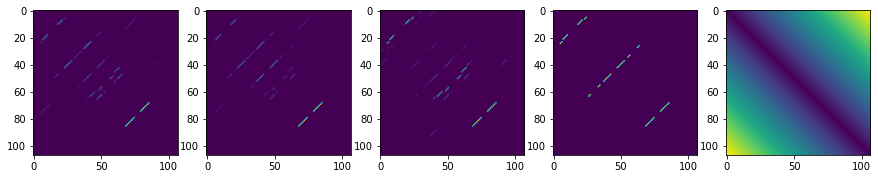

In [10]:
f, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(As.shape[-1]):
    ax[i].imshow(As[0, :, :, i].astype(np.float32))
plt.show()

# 1.4 Creating node features

We extract 25 features per base in our sequence (107x25 features for train & public test, 130x25 features for private test):
* One-hot-encoded base (AGCU) (4 features)
* One-hot-encoded loop type (provided) (7 features)
* one-hot-encoded positional feature (index % 3) (3 features)
* certainty: fraction of packages (3 different ones) that predict `(`, `)` or `.`  (3 features)
* CapR loop type probabilities (6 features)
* BPP sum and number of zeroese (2 features)

In [11]:
arnie_train_features = pickle.load(open('../input/covid19-mrna-augmentation-data-and-features/arnie/arnie/train_features.p', 'rb'))
arnie_test_features = pickle.load(open('../input/covid19-mrna-augmentation-data-and-features/arnie/arnie/test_features.p', 'rb'))
capr_train_features = pickle.load(open('../input/covid19-mrna-augmentation-data-and-features/CapR_train.pickle', 'rb'))
capr_test_features = pickle.load(open('../input/covid19-mrna-augmentation-data-and-features/CapR_test.pickle', 'rb'))

In [12]:
## sequence
def return_ohe(n, i):
    tmp = [0] * n
    tmp[i] = 1
    return tmp

def get_input(train):
    mapping = {}
    vocab = ["A", "G", "C", "U"]
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    X_node = np.stack(train["sequence"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))

    mapping = {}
    vocab = ["S", "M", "I", "B", "H", "E", "X"]
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    X_loop = np.stack(train["predicted_loop_type"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))
    
    X_pos1 = np.stack(train["sequence"].apply(lambda x : np.arange(len(x)) % 3 == 0))[:,:,np.newaxis]
    X_pos2 = np.stack(train["sequence"].apply(lambda x : np.arange(len(x)) % 3 == 1))[:,:,np.newaxis]
    X_pos3 = np.stack(train["sequence"].apply(lambda x : np.arange(len(x)) % 3 == 2))[:,:,np.newaxis]

    X_certainty = np.zeros((X_pos1.shape[:2] + (3, )))
    X_loop_capr = np.zeros((X_pos1.shape[:2] + (6, )))
    X_bpp_sum = np.zeros((X_pos1.shape[:2] + (1, )))
    X_bpp_nb_zeroes = np.zeros((X_pos1.shape[:2] + (1, )))

    for k, mol_id in enumerate(train['id'].values):
        if mol_id in arnie_train_features:
            arr1 = np.array(list(arnie_train_features[mol_id]['mfe']['vienna_2']))
            arr2 = np.array(list(arnie_train_features[mol_id]['mfe']['contrafold_2']))
            arr3 = np.array(list(arnie_train_features[mol_id]['mfe']['rnastructure']))
        else:
            arr1 = np.array(list(arnie_test_features[mol_id]['mfe']['vienna_2']))
            arr2 = np.array(list(arnie_test_features[mol_id]['mfe']['contrafold_2']))
            arr3 = np.array(list(arnie_test_features[mol_id]['mfe']['rnastructure']))

        X_certainty[k, :, 0] = ((arr1 == '(') + (arr2 == '(') + (arr3 == '(')).astype(int) / 3
        X_certainty[k, :, 1] = ((arr1 == ')') + (arr2 == ')') + (arr3 == ')')).astype(int) / 3
        X_certainty[k, :, 2] = ((arr1 == '.') + (arr2 == '.') + (arr3 == '.')).astype(int) / 3
        
        if mol_id in capr_train_features:
            X_loop_capr[k] = np.array([list(map(float, i.split()[1:])) for i in capr_train_features[mol_id].split('\n')[1:-2]]).T
        else:
            X_loop_capr[k] = np.array([list(map(float, i.split()[1:])) for i in capr_test_features[mol_id].split('\n')[1:-2]]).T

        bpp = np.load(f"../input/stanford-covid-vaccine/bpps/{mol_id}.npy").astype(np.float16)
        X_bpp_sum[k] = bpp.sum(axis=1)[:, None]
        X_bpp_nb_zeroes[k] = ((bpp == 0).sum(axis=1) / X_pos1.shape[1])[:, None]


    X_node = np.concatenate([X_node, X_loop, X_pos1, X_pos2, X_pos3, X_certainty, X_loop_capr, X_bpp_sum, X_bpp_nb_zeroes], axis = 2)
    return X_node

X_node = get_input(train).astype(np.float16)
X_node_pub = get_input(test_pub).astype(np.float16)
X_node_pri = get_input(test_pri).astype(np.float16)

In [13]:
print(X_node.shape, X_node_pub.shape, X_node_pri.shape)

(4800, 107, 25) (1258, 107, 25) (6010, 130, 25)


In [14]:
del arnie_train_features, arnie_test_features, capr_train_features, capr_test_features

# 1.5 Extracting the targets

5 targets, including the 2 non-scored ones (deg_pH10 and deg_50C) as they increase the performance of the 3 others when trained jointly on all 5.

In [15]:
targets = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

y_train = []
seq_len = train["seq_length"].iloc[0]
seq_len_target = train["seq_scored"].iloc[0]
ignore = -10000
ignore_length = seq_len - seq_len_target
for target in targets:
    y = np.vstack(train[target])
    dummy = np.zeros([y.shape[0], ignore_length]) + ignore
    y = np.hstack([y, dummy])
    y_train.append(y)
y = np.stack(y_train, axis = 2)
print(y.shape)

(4800, 107, 5)


In [16]:
N_NODE_FEATURES = X_node.shape[2]
N_EDGE_FEATURES = As.shape[3]

# 2. Creating the model & training

In [17]:
import tensorflow as tf
from tensorflow.keras import layers as L
import tensorflow_addons as tfa
from tensorflow.keras import backend as K
from sklearn.utils import shuffle
from sklearn.model_selection import GroupKFold

In [18]:
ae_epochs = 25
ae_epochs_each = 5
ae_batch_size = 32

epochs_list = [30, 10, 3, 3, 5, 5]
batch_size_list = [8, 16, 32, 64, 128, 256]

In [19]:
def mcrmse(t, p, seq_len_target = seq_len_target):
    score = np.mean(np.sqrt(tf.keras.losses.mean_squared_error(t, p))[:, :seq_len_target])
    return score

def rmse(y_actual, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_actual, y_pred)
    return K.sqrt(mse)

def mcrmse_loss(y_actual, y_pred, num_scored=5):
    y_actual = y_actual[:, :68, :]
    y_pred = y_pred[:, :68, :]
    score = 0
    for i in range(num_scored):
        score += rmse(y_actual[:, :, i], y_pred[:, :, i]) / num_scored
    return score

def attention(x_inner, x_outer, n_factor, dropout):
    x_Q =  L.Conv1D(n_factor, 1, activation='linear', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(x_inner)
    x_K =  L.Conv1D(n_factor, 1, activation='linear', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(x_outer)
    x_V =  L.Conv1D(n_factor, 1, activation='linear', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(x_outer)
    x_KT = L.Permute((2, 1))(x_K)
    res = L.Lambda(lambda c: K.batch_dot(c[0], c[1]) / np.sqrt(n_factor))([x_Q, x_KT])
    att = L.Lambda(lambda c: K.softmax(c, axis=-1))(res)
    att = L.Lambda(lambda c: K.batch_dot(c[0], c[1]))([att, x_V])
    return att

def multi_head_attention(x, y, n_factor, n_head, dropout):
    if n_head == 1:
        att = attention(x, y, n_factor, dropout)
    else:
        n_factor_head = n_factor // n_head
        heads = [attention(x, y, n_factor_head, dropout) for i in range(n_head)]
        att = L.Concatenate()(heads)
        att = L.Dense(n_factor, 
                      kernel_initializer='glorot_uniform',
                      bias_initializer='glorot_uniform',
                     )(att)
    x = L.Add()([x, att])
    x = L.LayerNormalization()(x)
    if dropout > 0:
        x = L.Dropout(dropout)(x)
    return x

def res(x, unit, kernel = 3, rate = 0.1):
    h = L.Conv1D(unit, kernel, 1, padding = "same", activation = None)(x)
    h = L.LayerNormalization()(h)
    h = L.LeakyReLU()(h)
    h = L.Dropout(rate)(h)
    return L.Add()([x, h])

def forward(x, unit, kernel = 3, rate = 0.1):
#     h = L.Dense(unit, None)(x)
    h = L.Conv1D(unit, kernel, 1, padding = "same", activation = None)(x)
    h = L.LayerNormalization()(h)
    h = L.Dropout(rate)(h)
#         h = tf.keras.activations.swish(h)
    h = L.LeakyReLU()(h)
    h = res(h, unit, kernel, rate)
    return h

def adj_attn(x, adj, unit, n = 2, rate = 0.1):
    x_a = x
    x_as = []
    for i in range(n):
        x_a = forward(x_a, unit)
        x_a = tf.matmul(adj, x_a)
        x_as.append(x_a)
    if n == 1:
        x_a = x_as[0]
    else:
        x_a = L.Concatenate()(x_as)
    x_a = forward(x_a, unit)
    return x_a


def get_base(config):
    node = tf.keras.Input(shape = (None, N_NODE_FEATURES), name = "node")
    adj = tf.keras.Input(shape = (None, None, N_EDGE_FEATURES), name = "adj")
    
    adj_learned = L.Dense(1, "relu")(adj)
    adj_all = L.Concatenate(axis = 3)([adj, adj_learned])
        
    xs = []
    xs.append(node)
    x1 = forward(node, 128, kernel = 3, rate = 0.0)
    x2 = forward(x1, 64, kernel = 6, rate = 0.0)
    x3 = forward(x2, 32, kernel = 15, rate = 0.0)
    x4 = forward(x3, 16, kernel = 30, rate = 0.0)
    x = L.Concatenate()([x1, x2, x3, x4])
    
    for unit in [128, 64]:
        x_as = []
        for i in range(adj_all.shape[3]):
            x_a = adj_attn(x, adj_all[:, :, :, i], unit, rate = 0.0)
            x_as.append(x_a)
        x_c = forward(x, unit, kernel = 30)
        
        x = L.Concatenate()(x_as + [x_c])
        x = forward(x, unit)
        x = multi_head_attention(x, x, unit, 4, 0.0)
        xs.append(x)
        
    x = L.Concatenate()(xs)

    model = tf.keras.Model(inputs = [node, adj], outputs = [x])
    return model


def get_ae_model(base, config):
    node = tf.keras.Input(shape = (None, N_NODE_FEATURES), name = "node")
    adj = tf.keras.Input(shape = (None, None, N_EDGE_FEATURES), name = "adj")

    x = base([L.SpatialDropout1D(0.3)(node), adj])
    x = forward(x, 64, rate = 0.3)
    p = L.Dense(N_NODE_FEATURES, "sigmoid")(x)
    
    loss = tf.reduce_mean(tf.math.abs(node - p))
    model = tf.keras.Model(inputs = [node, adj], outputs = [loss])
    
    opt = get_optimizer()
    model.compile(optimizer = opt, loss = lambda t, y : y)
    return model

def gru_layer(hidden_dim, dropout):
    return L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer = 'orthogonal'))
def lstm_layer(hidden_dim, dropout):
    return L.Bidirectional(L.LSTM(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer = 'orthogonal'))

def get_model(base, config):
    node = tf.keras.Input(shape = (None, N_NODE_FEATURES), name = "node")
    adj = tf.keras.Input(shape = (None, None, N_EDGE_FEATURES), name = "adj")
    
    x = base([node, adj])
    x = lstm_layer(256, 0.5)(x)
    x = lstm_layer(256, 0.5)(x)
    x = L.Dense(5, None)(x)

    model = tf.keras.Model(inputs = [node, adj], outputs = [x])
    
    opt = get_optimizer()
    model.compile(optimizer = opt, loss = mcrmse_loss)
    return model

def get_optimizer():
    adam = tf.optimizers.Adam()
    return adam

In [20]:
config = {}

if ae_epochs > 0:
    base = get_base(config)
    ae_model = get_ae_model(base, config)
    ## TODO : simultaneous train
    for i in range(ae_epochs//ae_epochs_each):
        print(f"------ {i} ------")
        print("--- train ---")
        X_node_shuff, As_shuff = shuffle(X_node, As)
        ae_model.fit([X_node_shuff, As_shuff], [np.zeros((len(X_node)))],
                  epochs = ae_epochs_each,
                  batch_size = ae_batch_size)
        
        print("--- public ---")
        X_node_pub_shuff, As_pub_shuff = shuffle(X_node_pub, As_pub)
        ae_model.fit([X_node_pub_shuff, As_pub_shuff], [np.zeros((len(X_node_pub)))],
                  epochs = ae_epochs_each,
                  batch_size = ae_batch_size)
        
        print("--- private ---")
        X_node_pri_shuff, As_pri_shuff = shuffle(X_node_pri, As_pri)
        ae_model.fit([X_node_pri_shuff, As_pri_shuff], [np.zeros((len(X_node_pri)))],
                  epochs = ae_epochs_each,
                  batch_size = ae_batch_size)
        gc.collect()
    print("****** save ae model ******")
    base.save_weights("base_ae_lstm_lstm")

------ 0 ------
--- train ---
150/150 [==============================] - 15s 102ms/step - loss: 0.1468
--- public ---
40/40 [==============================] - 5s 116ms/step - loss: 0.0769
--- private ---
188/188 [==============================] - 23s 120ms/step - loss: 0.0518
****** save ae model ******


In [21]:
del ae_model

gc.collect()

10440

In [22]:
np.save('X_node_pub.npy', X_node_pub)
np.save('X_node_pri.npy', X_node_pri)
np.save('As_pub.npy', As_pub)
np.save('As_pri.npy', As_pri)

del X_node_pub, X_node_pri, As_pub, As_pri, X_node_shuff, As_shuff, X_node_pub_shuff, As_pub_shuff, X_node_pri_shuff, As_pri_shuff

In [23]:
kfold = GroupKFold(5)

config = {}
scores = []
preds = np.zeros([len(X_node), X_node.shape[1], 5])
X_node, As, y, weights, groups_shuffled, SN_filter_mask = shuffle(X_node, As, y, train.signal_to_noise.values, train['id'], (train['SN_filter'] == 1).values)
del train
for i, (tr_idx, va_idx) in enumerate(kfold.split(X_node, As, groups_shuffled)):
    print(f"------ fold {i} start -----")
    X_node_tr = X_node[tr_idx]
    X_node_va = X_node[va_idx]
    As_tr = As[tr_idx]
    As_va = As[va_idx]  
    y_tr = y[tr_idx]
    y_va = y[va_idx]
    w_trn = np.log(weights[tr_idx]+1.105)/2
    
    base = get_base(config)
    if ae_epochs > 0:
        print("****** load ae model ******")
        base.load_weights("base_ae_lstm_lstm")
    model = get_model(base, config)
    for epochs, batch_size in zip(epochs_list, batch_size_list):
        print(f"epochs : {epochs}, batch_size : {batch_size}")
        model.fit([X_node_tr, As_tr], [y_tr],
                  validation_data=([X_node_va[SN_filter_mask[va_idx]], As_va[SN_filter_mask[va_idx]]], [y_va[SN_filter_mask[va_idx]]]),
                  epochs = epochs,
                  sample_weight=w_trn/2,
                  batch_size = batch_size, validation_freq = 3)
        
    model.save_weights(f"model{i}_lstm_lstm")
    p = model.predict([X_node_va, As_va])
    for col in range(5):
        print(targets[col], ((p[:, :68, col][SN_filter_mask[va_idx]] - y_va[:,:68,col][SN_filter_mask[va_idx]]) ** 2).mean() ** .5)
    scores.append(np.mean(mcrmse_loss(y_va, p)))
    
    print(f"fold {i}: mcrmse {scores[-1]}")
    preds[va_idx] = p
    
    gc.collect()

------ fold 0 start -----
****** load ae model ******
epochs : 1, batch_size : 256
15/15 [==============================] - 8s 551ms/step - loss: 0.2328
reactivity 0.3952884187219692
deg_Mg_pH10 0.4957223950654
deg_pH10 0.4877043945404378
deg_Mg_50C 0.4600390590920768
deg_50C 0.3753641773868789
fold 0: mcrmse 0.5705066919326782
------ fold 1 start -----
****** load ae model ******
epochs : 1, batch_size : 256
15/15 [==============================] - 9s 567ms/step - loss: 0.2531
reactivity 0.394420553697772
deg_Mg_pH10 0.5016855179916028
deg_pH10 0.5140094322446686
deg_Mg_50C 0.4500155234393754
deg_50C 0.37748828697821446
fold 1: mcrmse 0.622940719127655
------ fold 2 start -----
****** load ae model ******
epochs : 1, batch_size : 256
15/15 [==============================] - 8s 561ms/step - loss: 0.2678
reactivity 0.43470002689847964
deg_Mg_pH10 0.526774612698896
deg_pH10 0.515111054528476
deg_Mg_50C 0.47215475408942414
deg_50C 0.3955008263504551
fold 2: mcrmse 0.6284493803977966
-----

In [24]:
preds_df = []
for p_ix, _id in zip(range(preds.shape[0]), groups_shuffled):
    for i in range(68):
        preds_df.append([f'{_id}_{i}', preds[p_ix, i, 0], preds[p_ix, i, 1], 
                         preds[p_ix, i, 3], y[p_ix, i, 0], y[p_ix, i, 1],
                         y[p_ix, i, 3], SN_filter_mask[p_ix]])
preds_df = pd.DataFrame(preds_df, columns=['id_seqpos', 'reactivity', 'deg_Mg_pH10', 
                                           'deg_Mg_50C', 'reactivity_gt', 'deg_Mg_pH10_gt', 
                                           'deg_Mg_50C_gt', 'SN_filter'])
preds_df = preds_df.groupby('id_seqpos').mean()
rmses = []
mses = []
for col in ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']:
    _rmse = ((preds_df[preds_df['SN_filter'] == 1][col] - preds_df[preds_df['SN_filter'] == 1][col+'_gt']) ** 2).mean() ** .5
    _mse = ((preds_df[preds_df['SN_filter'] == 1][col] - preds_df[preds_df['SN_filter'] == 1][col+'_gt']) ** 2).mean()
    rmses.append(_rmse)
    mses.append(_mse)
    print(col, _rmse, _mse)
print(np.mean(rmses), np.mean(mses))

reactivity 0.4142755960986902 0.1716242695229251
deg_Mg_pH10 0.5077816073306024 0.2578421607432501
deg_Mg_50C 0.4571073540264081 0.208947133105024
0.45972151915190024 0.21280452112373305


# 3. Inference

In [25]:
del X_node, As

In [26]:
X_node_pub = np.load('X_node_pub.npy')
X_node_pri = np.load('X_node_pri.npy')
As_pub = np.load('As_pub.npy')
As_pri = np.load('As_pri.npy')

In [27]:
p_pub = 0
p_pri = 0
for i in range(5):
    config = {}
    base = get_base(config)
    if ae_epochs > 0:
        print("****** load ae model ******")
        base.load_weights("base_ae_lstm_lstm")
    model = get_model(base, config)
    model.load_weights(f"model{i}_lstm_lstm")
    p_pub += model.predict([X_node_pub, As_pub]) / 5
    p_pri += model.predict([X_node_pri, As_pri]) / 5

for i, target in enumerate(targets):
    test_pub[target] = [list(p_pub[k, :, i]) for k in range(p_pub.shape[0])]
    test_pri[target] = [list(p_pri[k, :, i]) for k in range(p_pri.shape[0])]

****** load ae model ******
****** load ae model ******
****** load ae model ******
****** load ae model ******
****** load ae model ******


In [28]:
preds_ls = []
for df, preds in [(test_pub, p_pub), (test_pri, p_pri)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=targets)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_ls.append(single_df)

preds_df = pd.concat(preds_ls)
preds_df = preds_df.groupby('id_seqpos').mean()
preds_df.to_csv("submission_lstm_lstm.csv")
preds_df.head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
id_seqpos,,,,,
id_00073f8be_0,0.549876,0.523977,0.955659,0.633907,0.604943
id_00073f8be_1,0.616222,0.575488,0.955579,0.713923,0.661382
id_00073f8be_10,0.256883,0.369454,0.324495,0.342207,0.290394
id_00073f8be_100,0.492760,0.493667,0.510421,0.605250,0.542404
id_00073f8be_101,0.482626,0.483296,0.473538,0.594109,0.528667
